# IMPORTS

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


# SET UP GOOGLE COLAB

In [ ]:
# Load the drive helper and mount
from google.colab import drive

# this will prompt for authorization
drive.mount('/content/drive')

In [3]:
# after executing the cell above, Drive files available in "/content/drive/My Drive"
! ls "/content/drive/My Drive"

'Colab Notebooks'


# LOAD DATASET

In [4]:
os.getcwd()

'/content'

In [0]:
# Load the datasets
current_path = os.getcwd()
file = '/drive/My Drive/Colab Notebooks'+'/datasets/mnist_data/mnist.pkl.gz'
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [0]:
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_validation.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [0]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ \
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [0]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

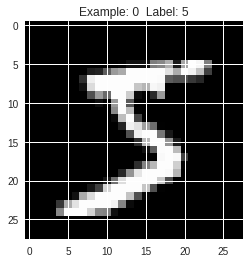

In [9]:
# View the first digit
view_digit(X_train, y_train, 0)

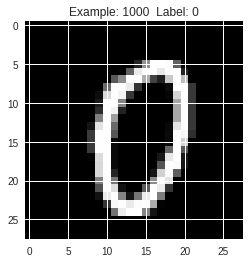

In [10]:
view_digit(X_train, y_train, 1000)

# CONFIRM USE OF GPU

In [11]:
# Confirm use of GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# Convolutional Neural Network (CNN)

- In this section we first build a regular CNN to classify MNIST images. We use early stopping and save the best model to disk. 
- Feel free to skip if interested in the GAN problem only. 

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [0]:
# Train CNN
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

cnn_history = model.fit(X_train_keras, y_train_keras, 
          validation_data=(X_validation_keras, y_validation_keras), \
          epochs=100)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 23s 459us/step - loss: 0.1901 - acc: 0.9399 - val_loss: 0.0551 - val_acc: 0.9836
Epoch 2/100
50000/50000 [==============================] - 19s 387us/step - loss: 0.0739 - acc: 0.9782 - val_loss: 0.0340 - val_acc: 0.9904
Epoch 3/100
50000/50000 [==============================] - 19s 387us/step - loss: 0.0548 - acc: 0.9840 - val_loss: 0.0367 - val_acc: 0.9901
Epoch 4/100
50000/50000 [==============================] - 19s 387us/step - loss: 0.0445 - acc: 0.9867 - val_loss: 0.0365 - val_acc: 0.9913
Epoch 5/100
50000/50000 [==============================] - 19s 386us/step - loss: 0.0393 - acc: 0.9881 - val_loss: 0.0314 - val_acc: 0.9924
Epoch 6/100
50000/50000 [==============================] - 19s 386us/step - loss: 0.0351 - acc: 0.9889 - val_loss: 0.0365 - val_acc: 0.9923
Epoch 7/100
50000/50000 [==============================] - 19s

In [0]:
print(cnn_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


CNN Final Accuracy 0.99454


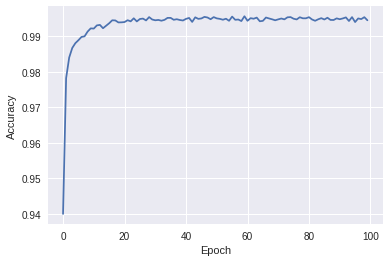

In [0]:
# Plot Accuracy of CNN
print("CNN Final Accuracy", cnn_history.history['acc'][-1])
pd.Series(cnn_history.history['acc']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [0]:
# save the Keras CNN model
model.save('cnn_model.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
# can load the model without retraining
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model_loaded = load_model('cnn_model.h5')

In [0]:
def load_and_evaluate(model_name, return_model=False):
    """
    Load in a trained model and evaluate with log loss and accuracy
    """

    # model = load_model(f'{model_dir}{model_name}.h5')
    model = load_model(model_name + '.h5')
    r = model.evaluate(X_validation_keras, y_validation_keras, 
                       batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [0]:
model_loaded = load_and_evaluate('cnn_model', return_model=True)

10000/10000 [==============================] - 2s 162us/step
Cross Entropy: 0.0686
Accuracy: 99.34%


In [0]:
# train with early stopping and save best model to disk
from keras.callbacks import EarlyStopping, ModelCheckpoint

def make_callbacks(model_name, save=True):
    """
    Make list of callbacks for training
    """
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks('cnn_model_early-stop')

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_keras, y_train_keras, 
          validation_data=(X_validation_keras, y_validation_keras),
          epochs=100,
          callbacks = callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 22s 441us/step - loss: 0.1820 - acc: 0.9442 - val_loss: 0.0466 - val_acc: 0.9861
Epoch 2/100
50000/50000 [==============================] - 20s 401us/step - loss: 0.0695 - acc: 0.9794 - val_loss: 0.0342 - val_acc: 0.9908
Epoch 3/100
50000/50000 [==============================] - 20s 397us/step - loss: 0.0520 - acc: 0.9846 - val_loss: 0.0340 - val_acc: 0.9895
Epoch 4/100
50000/50000 [==============================] - 19s 390us/step - loss: 0.0460 - acc: 0.9858 - val_loss: 0.0290 - val_acc: 0.9923
Epoch 5/100
50000/50000 [==============================] - 19s 390us/step - loss: 0.0382 - acc: 0.9879 - val_loss: 0.0278 - val_acc: 0.9916
Epoch 6/100
50000/50000 [==============================] - 20s 391us/step - loss: 0.0357 - acc: 0.9893 - val_loss: 0.0374 - val_acc: 0.9923
Epoch 7/100
50000/50000 [==============================] - 20s 390us/step - loss: 0.0315 - acc: 0.9905 - val_l

CNN Final Accuracy 0.99428


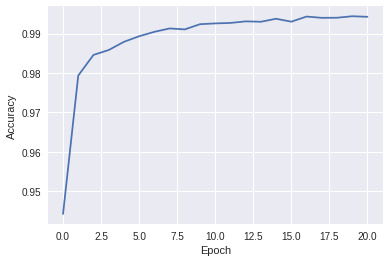

In [0]:
# Plot Accuracy of CNN
print("CNN Final Accuracy", history.history['acc'][-1])
pd.Series(history.history['acc']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# DEEP CONVOLUTIONAL GAN (DCGAN) NETWORK

- In this section we build and train a Deep Convolutional GAN, in order to create synthetic fake images that look similar to the original MNIST data. 
- The GAN network consists of a generator and discriminator that play against each other. 
- The discriminator is a referee that tries to tell the difference between real and fake images, whereas the generator tries to make the discriminator's life hard. In equilibrium the discrimnator cannot tell the difference between real and fake images, resulting in an accuracy of 50% (i.e., random guessing).
- The training process is quite involved, with several comments trying to elucidate the idea behind this non-standard training process. 
- At the end we plot some fake images generated by our GAN network.

In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))


In [0]:
class DCGAN_MNIST(object):
    
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train
        
        # discriminator
        self.D = self.discriminator()
        # generator
        self.G = self.generator()
        # discriminator model
        self.DM = self.discriminator_model()
        # adversarial model (discrimnator stacked on top of generator)
        self.AM = self.adversarial_model() 
    
    
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8,
                  window=5, input_dim=100, output_depth=1): 
        gen = Sequential()
        gen.add(Dense(dim*dim*depth, input_dim=input_dim))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))
        gen.add(Reshape((dim, dim, depth)))
        gen.add(Dropout(dropout))
        
        gen.add(UpSampling2D())
        gen.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(UpSampling2D())
        gen.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(Conv2DTranspose(output_depth, window, padding='same'))
        gen.add(Activation('sigmoid'))
        gen.summary()
        return gen

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3): 
        dis = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        dis.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Flatten())
        dis.add(Dense(1))
        dis.add(Activation('sigmoid'))
        dis.summary()
        return dis

    def discriminator_model(self):
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        DM = Sequential()
        DM.add(self.D)
        DM.compile(loss='binary_crossentropy',
                   optimizer=optimizer, metrics=['accuracy'])
        return DM

    def adversarial_model(self):
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        AM = Sequential()
        AM.add(self.G)
        # Set discriminator weights to non-trainable
        # (will only apply to the `gan` model)
        # self.D.trainable = False
        AM.add(self.D)
        AM.compile(loss='binary_crossentropy',
                   optimizer=optimizer, metrics=['accuracy'])
        return AM
    
    
    
    # TRAINING
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        
        # loop over epochs
        for i in range(train_steps):
            # get random REAL training samples 
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            # noise vector as input for generator
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            # generate fake images
            images_fake = self.G.predict(noise)
            # labeled sample contains real and fake images
            x = np.concatenate((images_train, images_fake))
            # build label vector (real=1, fake=0)
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            # add random noise to the labels - important trick!
            #y += 0.05 * np.random.random(y.shape)
            
            # train discriminator with real and fake images
            # keras train_on_batch runs a single gradient update on a single batch of data
            # returns loss and accuracy in list of scalars
            d_loss = self.DM.train_on_batch(x, y)
            
            # train adversial network (generator+discriminator) with fake images
            # NOTE: here fake images are labelled with y=1, since lose corresponds to fake image detected as fake
            # generator does well if fake image declared as real in output of adversial network
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.AM.train_on_batch(noise, y)
            
            # track training progress in log message
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            
            # print log messages
            print(log_mesg)
            
            # plot and save fake sample during training every interval steps
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, 
                        samples=noise_input.shape[0],
                        noise=noise_input, step=(i+1))
    
    # PLOT FAKE IMAGES
    def plot_images(self, save2file=False, fake=True, samples=16,
                    noise=None, step=0):
        
        # location for storing fake images 
        current_path = os.getcwd()
        file = '/drive/My Drive/Colab Notebooks/images/synthetic_mnist/'
        filename = 'mnist.png'
        
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.G.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [19]:
dcgan_mnist = DCGAN_MNIST(X_train_keras)
dcgan_mnist.train(train_steps=4000, batch_size=256, save_interval=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         819456    
__________

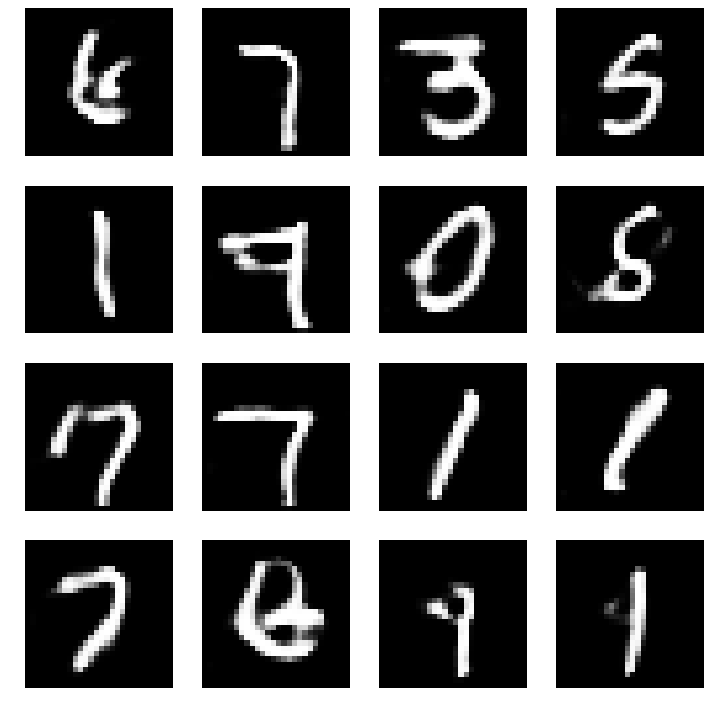

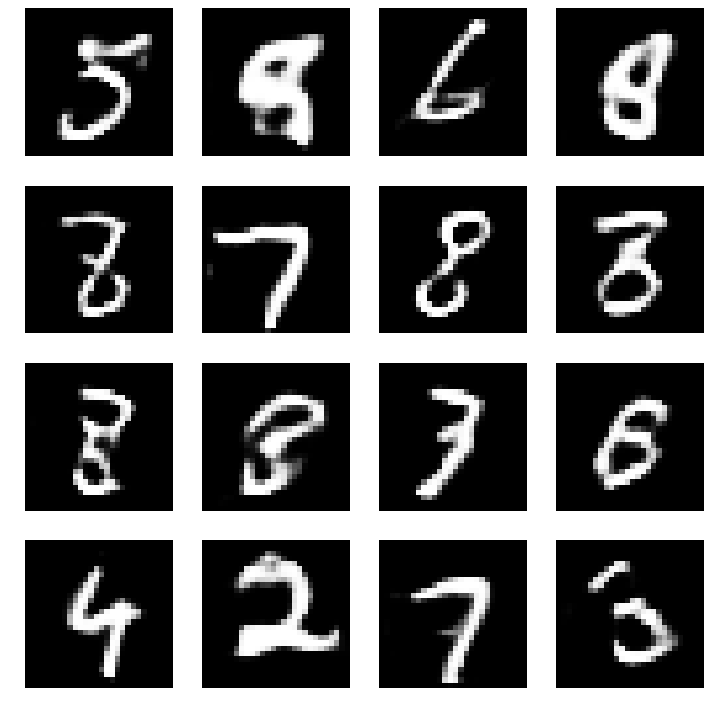

In [20]:
# Generate batch of synthetic MNIST images
dcgan_mnist.plot_images(fake=True)
dcgan_mnist.plot_images(fake=True)

In [0]:
class DCGAN_MNIST(object):
    
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train
        
        # discriminator
        self.D = self.discriminator()
        # generator
        self.G = self.generator()
        # discriminator model
        self.DM = self.discriminator_model()
        # adversarial model (discrimnator stacked on top of generator)
        self.AM = self.adversarial_model() 
    
    
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8,
                  window=5, input_dim=100, output_depth=1): 
        gen = Sequential()
        gen.add(Dense(dim*dim*depth, input_dim=input_dim))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))
        gen.add(Reshape((dim, dim, depth)))
        gen.add(Dropout(dropout))
        
        gen.add(UpSampling2D())
        gen.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(UpSampling2D())
        gen.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        gen.add(BatchNormalization(momentum=momentum))
        gen.add(Activation('relu'))

        gen.add(Conv2DTranspose(output_depth, window, padding='same'))
        gen.add(Activation('sigmoid'))
        gen.summary()
        return gen

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3): 
        dis = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        dis.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        dis.add(LeakyReLU(alpha=alpha))
        dis.add(Dropout(dropout))

        dis.add(Flatten())
        dis.add(Dense(1))
        dis.add(Activation('sigmoid'))
        dis.summary()
        return dis

    def discriminator_model(self):
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        DM = Sequential()
        DM.add(self.D)
        DM.compile(loss='binary_crossentropy',
                   optimizer=optimizer, metrics=['accuracy'])
        return DM

    def adversarial_model(self):
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        AM = Sequential()
        AM.add(self.G)
        # Set discriminator weights to non-trainable
        # (will only apply to the `gan` model)
        # self.D.trainable = False
        AM.add(self.D)
        AM.compile(loss='binary_crossentropy',
                   optimizer=optimizer, metrics=['accuracy'])
        return AM
    
    
    
    # TRAINING
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        
        # loop over epochs
        for i in range(train_steps):
            # get random REAL training samples 
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            # noise vector as input for generator
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            # generate fake images
            images_fake = self.G.predict(noise)
            # labeled sample contains real and fake images
            x = np.concatenate((images_train, images_fake))
            # build label vector (real=1, fake=0)
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            # add random noise to the labels - important trick!
            y += 0.05 * np.random.random(y.shape)
            
            # train discriminator with real and fake images
            # keras train_on_batch runs a single gradient update on a single batch of data
            # returns loss and accuracy in list of scalars
            d_loss = self.DM.train_on_batch(x, y)
            
            # train adversial network (generator+discriminator) with fake images
            # NOTE: here fake images are labelled with y=1, since lose corresponds to fake image detected as fake
            # generator does well if fake image declared as real in output of adversial network
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.AM.train_on_batch(noise, y)
            
            # track training progress in log message
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            
            # print log messages
            plot_interval = 100
            if i%plot_interval==0:
                print(log_mesg)
            
            # plot and save fake sample during training every interval steps
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, 
                        samples=noise_input.shape[0],
                        noise=noise_input, step=(i+1))
    
    # PLOT FAKE IMAGES
    def plot_images(self, save2file=False, fake=True, samples=16,
                    noise=None, step=0):
        
        # location for storing fake images 
        current_path = os.getcwd()
        file = '/drive/My Drive/Colab Notebooks/images/synthetic_mnist/'
        filename = 'mnist.png'
        
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist2_%d.png" % step
            images = self.G.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [24]:
# added some noise to labels
dcgan_mnist2 = DCGAN_MNIST(X_train_keras)
dcgan_mnist2.train(train_steps=10000, batch_size=256, save_interval=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)         819456    
__________

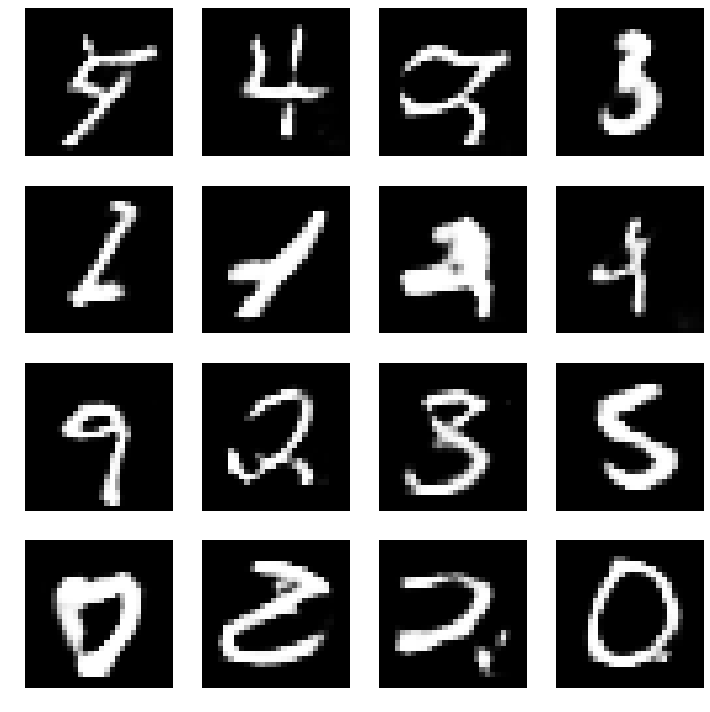

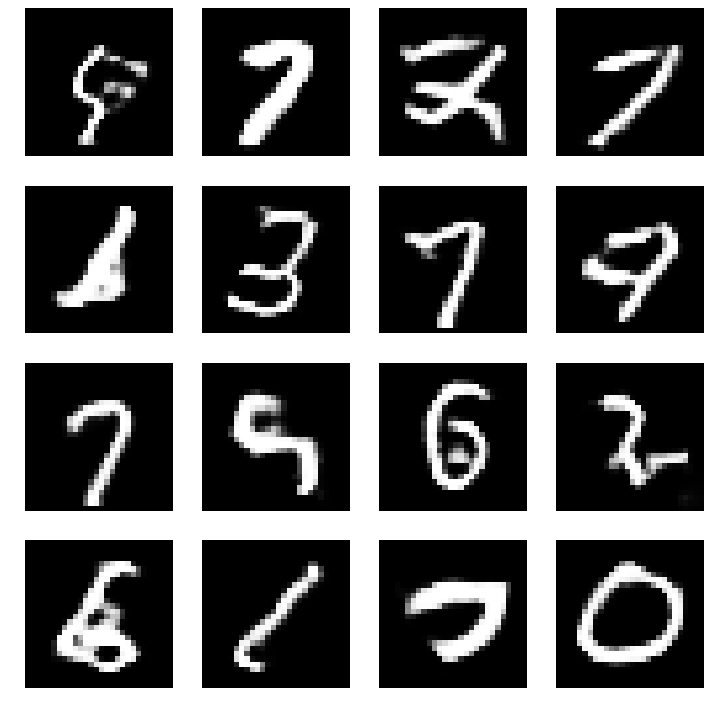

In [25]:
# Generate batch of synthetic MNIST images
dcgan_mnist2.plot_images(fake=True)
dcgan_mnist2.plot_images(fake=True)